---
title: MRPyMC3: Multilevel Regression and Poststratification with PyMC3
tags: PyMC3, Bayesian Statistics
---

A few weeks ago, [YouGov](https://today.yougov.com/) correctly [predicted](https://yougov.co.uk/uk-general-election-2017/#/uk-elections-charts-anchor) a hung parliament as a result of the 2017 UK general election, to the astonishment of many commentators.  YouGov's predictions were [based](https://yougov.co.uk/news/2017/05/31/how-yougov-model-2017-general-election-works/) on a technique called multilevel regression with poststratification, or MRP for short (Andrew Gelman playfully refers to it as [Mister P](http://andrewgelman.com/2009/05/09/the_next_suprem/)).

I was impressed with YouGov's prediction and decided to work through an MRP example to improve my understanding of this technique.  Since all of the applications of MRP I have found online involve `R`'s [`lme4`](https://cran.r-project.org/web/packages/lme4/index.html) package or [Stan](http://mc-stan.org/), I also thought this was a good opportunity to illustrate MRP in Python with PyMC3.  This post is essentially a port of [Jonathan Kastellec](http://www.princeton.edu/~jkastell/)'s excellent [MRP primer](http://www.princeton.edu/~jkastell/mrp_primer.html) to Python and PyMC3.  I am very grateful for his clear exposition of MRP and willingness to share a relevant data set.

MRP was developed to estimate American state-level opinions from national polls.  This sort of estimation is crucial to understanding American politics at the national level, as many of the important political positions of the federal government are impacted by state-level elections:

* the president is chosen by the Electoral College, which (with a few exceptions) votes according to state-level vote totals,
* senators are chosen by state-level elections,
* many political and all judicial (notably Supreme Court) appointees require Senate approval, and therefore are subject to indirect state-level elections.

Of course, as YouGov demonstrates, MRP is more widely applicable than estimation of state-level opinion.

In this post, we will follow Kastellec's example of estimating state-level opinion about gay marriage in 2005/2006 using a combination of three national polls.  We begin by loading a data set that consists of repsonses to the three national polls.

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import us

ModuleNotFoundError: No module named 'us'

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.patches import Polygon
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared

In [4]:
%%bash
if [ ! -e ./st99_d00.dbf ];
then
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.dbf
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shp
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shx
fi

In [5]:
SEED = 4260026 # from random.org, for reproducibility

np.random.seed(SEED)

We load only the columns which we will use in the analysis and transform categorical variables to be zero-indexed.

In [6]:
def to_zero_indexed(col):
    return lambda df: (df[col] - 1).astype(np.int64)

In [7]:
DATA_PREFIX = 'http://www.princeton.edu/~jkastell/MRP_primer/'

survey_df = (pd.read_stata(os.path.join(DATA_PREFIX, 'gay_marriage_megapoll.dta'),
                           columns=['race_wbh', 'age_cat', 'edu_cat', 'female',
                                    'state_initnum', 'state', 'region_cat', 'region', 'statename',
                                    'poll', 'yes_of_all'])
               .dropna(subset=['race_wbh', 'age_cat', 'edu_cat', 'state_initnum'])
               .assign(state_initnum=to_zero_indexed('state_initnum'),
                       race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat'),
                       region_cat=to_zero_indexed('region_cat')))

In [8]:
survey_df.head()

,race_wbh,age_cat,edu_cat,female,state_initnum,state,region_cat,region,statename,poll,yes_of_all
0,0,2,2,1,22,MI,1,midwest,michigan,Gall2005Aug22,0
1,0,2,3,0,10,GA,2,south,georgia,Gall2005Aug22,0
2,2,0,3,0,34,NY,0,northeast,new york,Gall2005Aug22,1
3,0,3,3,1,30,NH,0,northeast,new hampshire,Gall2005Aug22,1
5,0,3,2,1,14,IL,1,midwest,illinois,Gall2005Aug22,0


These three surveys collected data from roughly 6,300 respondents during 2005 and 2006.

In [9]:
survey_df.shape[0]

6341

We see that the number of respondents varies widely between states.

In [10]:
def state_plot(state_data, cmap, norm, cbar=True, default=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = plt.gcf()

    m = Basemap(llcrnrlon=-121, llcrnrlat=20,
                urcrnrlon=-62, urcrnrlat=51,
                projection='lcc',
                lat_1=32, lat_2=45, lon_0=-95)
    m.readshapefile('st99_d00', name='states', drawbounds=True)

    for state_info, state_seg in zip(m.states_info, m.states):
        if state_info['NAME'] == 'Alaska':
            state_seg = list(map(lambda xy: (0.35 * xy[0] + 1100000, 0.35 * xy[1] - 1300000), state_seg))
        elif state_info['NAME'] == 'Hawaii' and float(state_info['AREA']) > 0.005:
            state_seg = list(map(lambda xy: (xy[0] + 5100000, xy[1] - 1400000), state_seg))

        try:
            state_datum = state_data.loc[us.states.lookup(state_info['NAME']).abbr]   
        except KeyError:
            state_datum = default
        
        if state_datum is not None:
            color = rgb2hex(cmap(norm(state_datum))) 

            poly = Polygon(state_seg, facecolor=color, edgecolor='#000000')
            ax.add_patch(poly)
    
    if cbar:
        cbar_ax = fig.add_axes([0.925, 0.25, 0.04, 0.5])
        mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    else:
        cbar_ax = None
        
    return fig, ax, cbar_ax

In [11]:
state_counts = survey_df.groupby('state').size()

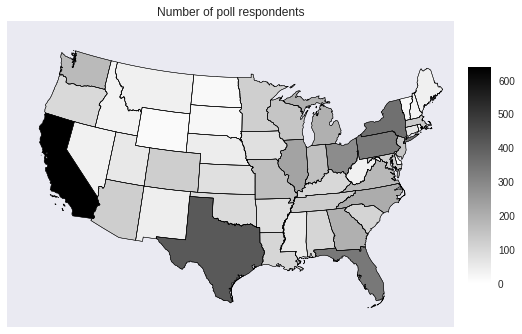

In [12]:
fig, ax, cbar_ax = state_plot(state_counts,
                              mpl.cm.binary,
                              Normalize(0, state_counts.max()),
                              default=None)

ax.set_title("Number of poll respondents");

Notably, there are no respondents from some less populous states, such as Alaska and Hawaii.

Faced with this data set, it is inuitively appealing to estimate state-level opinion by the observed proportion of that state's respondents that supported gay marriage.  This approach is known as disaggregation.

In [13]:
disagg_p = (survey_df.groupby('state')
                     .yes_of_all
                     .mean())

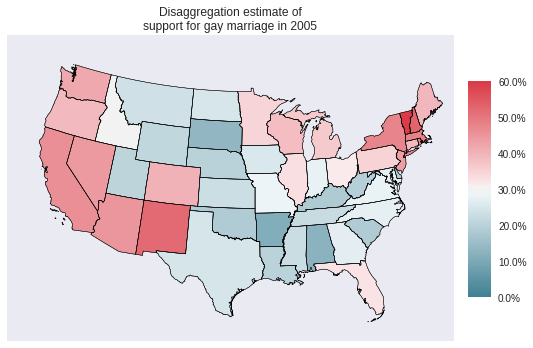

In [14]:
p_norm = Normalize(0., 0.6)
p_cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax, cbar_ax = state_plot(disagg_p, p_cmap, p_norm)

p_formatter = FuncFormatter(lambda prop, _: '{:.1%}'.format(p_norm.inverse(prop)))
cbar_ax.yaxis.set_major_formatter(p_formatter);

ax.set_title("Disaggregation estimate of\nsupport for gay marriage in 2005");

The simplicity of disaggregation is appealing, but it suffers from a number of drawbacks.  Obviously, it cannot estimate the state-level support for gay marriage in states with no respondents, such as Alaska and Hawaii.  Similarly, for small/low population states with some respondents, the sample size may be too small to produce reliable estimates of opinion.  This problem is exacerbated by the fact that for many issues, opinion is quite correlated with demographic factors such as age, race, education, gender, etc.  Many more states will not have sufficient sample size for each combination of these factors for the disaggregate estimate to be representative of that state's demographic compositon.

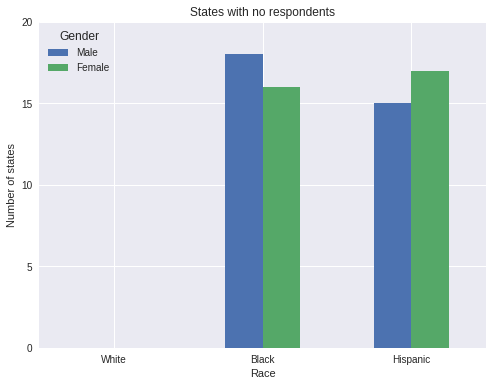

In [15]:
ax = (survey_df.groupby(['state', 'female', 'race_wbh'])
               .size()
               .unstack(level=['female', 'race_wbh'])
               .isnull()
               .sum()
               .unstack(level='female')
               .rename(index={0: 'White', 1: 'Black', 2: 'Hispanic'},
                       columns={0: 'Male', 1: 'Female'})
               .rename_axis('Race', axis=0)
               .rename_axis('Gender', axis=1)
               .plot(kind='bar', rot=0, figsize=(8, 6)))

ax.set_yticks(np.arange(0, 21, 5));
ax.set_ylabel("Number of states");

ax.set_title("States with no respondents");

The plot above illustrates this phenomenon; a number of states have no nonwhite male or female respondents.  Even more states will have very few such respondents.  This lack of data renders the disaggregation estimates suspect.  For further discussion and references on disaggregation (as well as an empirical comparison of disaggregation and MRP), consult Lax and Phillip's [_How Should We Estimate Public Opinion in the States?_](http://www.columbia.edu/~jrl2124/Lax%20Phillips%20-%20Estimating%20State%20Public%20Opinion.pdf).

MRP lessens the impact of this per-state respondent sparsity by first building a [multilevel model](https://en.wikipedia.org/wiki/Multilevel_model) of the relationship between respondents' states and demographic characteristics to opinion, and subsequently using the predictions of this multilevel model along with census data about the demographic composition of each state to predict state-level opinion.  Intuitively, the multilevel model employed by MRP is a principled statistical method for estimating, for example, how much men in Pennsylvania share opinions with men in other states versus how much they share opinions with women in Pennsylvania.  This partial pooling at both the state- and demographic-levels helps MRP impute the opinions of groups present in states that were not surveyed.

The rest of this post is focused primarily on the execution of MRP in Python with PyMC3.  For more detail on the theory and accuracy of MRP, consult the following (very incomplete) list of MRP resources:

* the [MRP primer](http://www.princeton.edu/~jkastell/MRP_primer/mrp_primer.pdf) from which our example is taken,
* Park, Gelman, and Bafumi's [_Bayesian Multilevel Estimation with Poststratification: State-Level Estimates from National Polls_](https://pdfs.semanticscholar.org/2008/bee9f8c2d7e41ac9c5c54489f41989a0d7ba.pdf), which assesses the accuracy of MRP in predicting the state-level results of the 1998 and 1992 US presidential elections,
* Section 14.1 of Gelman and Hill's [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/), which gives an expanded discussion of the example from the previous paper,
* Lax and Phillips' [_How Should We Estimate Public Opinion in The States?_](http://www.columbia.edu/~jrl2124/Lax%20Phillips%20-%20Estimating%20State%20Public%20Opinion.pdf), which is also mentioned above,
* Gelman's blog post [Mister P: What’s its secret sauce?](http://andrewgelman.com/2013/10/09/mister-p-whats-its-secret-sauce/), which is an extended discussion of several asssesments of MRP's accuracy ([1](https://academic.oup.com/pan/article-abstract/21/4/449/1544117/How-Does-Multilevel-Regression-and?redirectedFrom=fulltext), [2](http://www.columbia.edu/~jrl2124/mrp2.pdf)).

Following the MRP primer, our multilevel opinion model will include factors for state, race, gender, education, age, and poll.  In order to accelerate inference, we count the number of unique combinations of these factors, along with how many respondents with each combination supported gay marriage.

In [16]:
uniq_survey_df = (survey_df.groupby(['race_wbh', 'female', 'edu_cat', 'age_cat',
                                     'region_cat', 'state_initnum', 'poll'])
                           .yes_of_all
                           .agg({
                               'yes_of_all': 'sum',
                               'n': 'size'
                           })
                           .reset_index())

In [17]:
uniq_survey_df.head()

,race_wbh,female,edu_cat,age_cat,region_cat,state_initnum,poll,yes_of_all,n
0,0,0,0,0,0,6,Pew 2004Dec01,0,1
1,0,0,0,0,0,30,Gall2005Aug22,0,1
2,0,0,0,0,0,34,ABC 2004Jan15,1,1
3,0,0,0,0,0,38,Pew 2004Dec01,1,1
4,0,0,0,0,1,12,ABC 2004Jan15,0,1


This reduction adds negligible mathematical complexity (several Bernoulli distributions are combined into a single binomial distribution), but reduces the number of rows in the data set by nearly half.

In [18]:
uniq_survey_df.shape[0] / survey_df.shape[0]

0.5824002523261316

We will refer to each unique combination of state and demographic characteristics as a cell.  Let $n_i$ denote the number of respondents in cell $i$, $y_i$ the number of those respondents that supported gay marriage, and $p_i$ the probability that a member of the general population of cell $i$ supports gay marriage.  We build a Bayesian multilevel logistic regression model of opinion as follows.

$$\begin{align*}
\eta_i
    & = \beta_0 + \alpha^{\textrm{gender : race}}_{j(i)} + \alpha^{\textrm{age}}_{k(i)} + \alpha^{\textrm{edu}}_{l(i)} + \alpha^{\textrm{age : edu}}_{k(i),\ l(i)} + \alpha^{\textrm{state}}_{s(i)} + \alpha^{\textrm{poll}}_{m(i)} \\
\log \left(\frac{p_i}{1 - p_i}\right)
    & = \eta_i \\
y_i
    & \sim \textrm{Bernoulli}(n_i, p_i)
\end{align*}$$

Here each subscript indexed by $i$ is the categorical level of that characteristic for respondents in cell $i$.  The prior for the intercept is $\beta_0 \sim N(0, 5^2)$.  The prior for the effects of the interaction of gender and age is $\alpha^{\textrm{gender : race}}_j \sim N\left(0, \sigma_{\textrm{gender : race}}^2\right),$ with $\sigma_{\textrm{gender : race}} \sim \textrm{HalfCauchy}(5)$.  The priors on $\alpha^{\textrm{age}}_k,$ $\alpha^{\textrm{edu}}_l,$ $\alpha^{\textrm{age : edu}}_{k,\ l},$ and $\alpha^{\textrm{poll}}_m$ are defined similarly.  The prior on the state term, $\alpha^{\textrm{state}}_s$, includes state-level predictors for region of the country, religiosity, and support for John Kerry in the 2004 presidential election.

$$\begin{align*}
\alpha^{\textrm{state}}_s
    & \sim N\left(\alpha^{\textrm{region}}_s + \beta^{\textrm{relig}} x^{\textrm{relig}}_s + \beta^{\textrm{kerry}} x^{\textrm{kerry}}_s, \sigma^2_{\textrm{state}}\right)
\end{align*}$$

Here $x^{\textrm{relig}}_s$ is the log odds of the proportion of the state's residents that are evangelical Christian or Mormon, and $x^{\textrm{kerry}}_s$ is the log odds of the proportion of the state's voters that voted for John Kerry in 2004.  The priors on $\alpha^{\textrm{region}}_s$, $\beta^{\textrm{relig}}$, $\beta^{\textrm{kerry}}$ are the same as those on the analagous terms in the definition of $\eta$.

First we encode the respondent information.

In [19]:
def encode_gender_race(female, race_wbh):
    return (3 * female + race_wbh).values

def encode_age_edu(age, edu):
    return (4 * age + edu).values

In [20]:
gender_race = encode_gender_race(uniq_survey_df.female, uniq_survey_df.race_wbh)
n_gender_race = np.unique(gender_race).size

age = uniq_survey_df.age_cat.values
n_age = np.unique(age).size

edu = uniq_survey_df.edu_cat.values
n_edu = np.unique(edu).size

age_edu = encode_age_edu(uniq_survey_df.age_cat, uniq_survey_df.edu_cat)
n_age_edu = np.unique(age_edu).size

poll, poll_map = uniq_survey_df.poll.factorize()
n_poll = poll_map.size

region = uniq_survey_df.region_cat.values
n_region = np.unique(region).size

state = uniq_survey_df.state_initnum.values
n_state = 51

n = uniq_survey_df.n.values
yes_of_all = uniq_survey_df.yes_of_all.values

Next we load the state-level data and encode $x^{\textrm{relig}}$ and $x^{\textrm{kerry}}$.

In [21]:
STATE_URL = 'http://www.princeton.edu/~jkastell/MRP_primer/state_level_update.dta'

state_df = (pd.read_stata(STATE_URL,
                          columns=['sstate_initnum', 'sstate',
                                   'p_evang', 'p_mormon', 'kerry_04'])
              .rename(columns={'sstate_initnum': 'state_initnum', 'sstate': 'state'})
              .assign(state_initnum=to_zero_indexed('state_initnum'),
                      p_relig=lambda df: df.p_evang + df.p_mormon))

In [22]:
state_df.head()

,state_initnum,state,p_evang,p_mormon,kerry_04,p_relig
0,0,AK,12.440000,3.003126,35.500000,15.443126
1,1,AL,40.549999,0.458273,36.799999,41.008274
2,2,AR,43.070000,0.560113,44.599998,43.630112
3,3,AZ,9.410000,4.878735,44.400002,14.288734
4,4,CA,7.160000,1.557627,54.299999,8.717627


In [23]:
state_kerry = sp.special.logit(state_df.kerry_04.values / 100.)
state_relig = sp.special.logit(state_df.p_relig.values / 100.)

The state-level data doesn't contain region information, so we load census data in order to build a mapping between state and region.

In [24]:
CENSUS_URL = 'http://www.princeton.edu/~jkastell/MRP_primer/poststratification%202000.dta'

census_df = (pd.read_stata(CENSUS_URL)
               .rename(columns=lambda s: s.lstrip('c_').lower())
               .assign(race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat')))

In [25]:
census_df.head()

,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region
0,0,0,0,0,AK,467,21222.0,0.022005,west
1,0,1,0,0,AK,377,21222.0,0.017765,west
2,0,2,0,0,AK,419,21222.0,0.019744,west
3,0,3,0,0,AK,343,21222.0,0.016162,west
4,0,0,1,0,AK,958,21222.0,0.045142,west


In [26]:
state_df = (pd.merge(
                pd.merge((survey_df.groupby('region')
                                   .region_cat
                                   .first()
                                   .reset_index()),
                          (census_df[['state', 'region']].drop_duplicates()),
                          on='region')[['state', 'region_cat']],
                 state_df, on='state')
               .set_index('state_initnum')
               .sort_index())

In [27]:
state_df.head()

,state,region_cat,p_evang,p_mormon,kerry_04,p_relig
state_initnum,,,,,,
0,AK,3,12.440000,3.003126,35.500000,15.443126
1,AL,2,40.549999,0.458273,36.799999,41.008274
2,AR,2,43.070000,0.560113,44.599998,43.630112
3,AZ,3,9.410000,4.878735,44.400002,14.288734
4,CA,3,7.160000,1.557627,54.299999,8.717627


In [28]:
state_region = state_df.region_cat.values

Finally, we are ready to specify the model with PyMC3.  First, we wrap the predictors in `theano.shared` so that we can eventually replace the survey respondent's predictors with census predictors for posterior prediction (the poststratification step of MRP).

In [29]:
gender_race_ = shared(gender_race)
age_ = shared(age)
edu_ = shared(edu)
age_edu_ = shared(age_edu)
poll_ = shared(poll)
state_ = shared(state)
use_poll_ = shared(1)
n_ = shared(n)

We specify the model for $\alpha^{\textrm{state}}$.

In [30]:
def hierarchical_normal(name, shape, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.HalfCauchy('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [31]:
with pm.Model() as model:
    α_region = hierarchical_normal('region', n_region)
    β_relig = pm.Normal('relig', 0., 5.)
    β_kerry = pm.Normal('kerry', 0., 5.)
    μ_state = α_region[state_region] + β_relig * state_relig + β_kerry * state_kerry
    α_state = hierarchical_normal('state', n_state, μ=μ_state)

Throughout, we use a [non-centered parametrization](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for our hierarchical normal priors for more efficient sampling.  We now specify the rest of $\eta_i$.

In [32]:
with model:
    β0 = pm.Normal('β0', 0., 5.,
                   testval=sp.special.logit(survey_df.yes_of_all.mean()))
    α_gender_race = hierarchical_normal('gender_race', n_gender_race)
    α_age = hierarchical_normal('age', n_age)
    α_edu = hierarchical_normal('edu', n_edu)
    α_age_edu = hierarchical_normal('age_edu', n_age_edu)
    α_poll = hierarchical_normal('poll', n_poll)
    
    η = β0 \
        + α_gender_race[gender_race_] \
        + α_age[age_] \
        + α_edu[edu_] \
        + α_age_edu[age_edu_] \
        + α_state[state_] \
        + use_poll_ * α_poll[poll_]

Here the `theano.shared` variable `use_poll_` will allow us to ignore poll effects when we do posterior predictive sampling with census data.

Finally, we specify the likelihood and sample from the model using NUTS.

In [33]:
with model:
    p = pm.math.sigmoid(η)
    obs = pm.Binomial('obs', n_, p, observed=yes_of_all)

In [34]:
NUTS_KWARGS = {
    'target_accept': 0.99
}      

with model:
    trace = pm.sample(draws=1000, random_seed=SEED,
                      nuts_kwargs=NUTS_KWARGS, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2,800:  19%|█▉        | 37824/200000 [00:44<03:05, 876.09it/s]  
Convergence archived at 37900
Interrupted at 37,900 [18%]: Average Loss = 3,804.3
100%|██████████| 1500/1500 [08:29<00:00,  3.77it/s]


The marginal energy and energy transition distributions are fairly close, showing no obvious problem with NUTS.

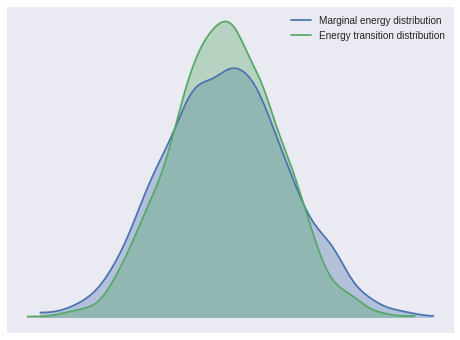

In [35]:
pm.energyplot(trace);

The Gelman-Rubin statistics for all parameters are quite close to one, indicating convergence.

In [36]:
max(np.max(score) for score in pm.gelman_rubin(trace).values())

1.0088100577623547

We are now ready for the post-stratification step of MRP.  First we combine the census and state-level data.

In [37]:
ps_df = pd.merge(census_df,
                 state_df[['state', 'region_cat']].reset_index(),
                 on='state')

In [38]:
ps_df.head()

,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region,state_initnum,region_cat
0,0,0,0,0,AK,467,21222.0,0.022005,west,0,3
1,0,1,0,0,AK,377,21222.0,0.017765,west,0,3
2,0,2,0,0,AK,419,21222.0,0.019744,west,0,3
3,0,3,0,0,AK,343,21222.0,0.016162,west,0,3
4,0,0,1,0,AK,958,21222.0,0.045142,west,0,3


Next we encode this combined data as before.

In [39]:
ps_gender_race = encode_gender_race(ps_df.female, ps_df.race_wbh)
ps_age = ps_df.age_cat.values
ps_edu = ps_df.edu_cat.values
ps_age_edu = encode_age_edu(ps_df.age_cat, ps_df.edu_cat)
ps_region = ps_df.region_cat.values
ps_state = ps_df.state_initnum.values
ps_n = ps_df.freq.values.astype(np.int64)

We now set the values of the `theano.shared` variables in our PyMC3 model to the poststratification data and sample from the posterior predictive distribution.

In [40]:
gender_race_.set_value(ps_gender_race)
age_.set_value(ps_age)
edu_.set_value(ps_edu)
age_edu_.set_value(ps_age_edu)
poll_.set_value(np.zeros_like(ps_gender_race))
state_.set_value(ps_state)
use_poll_.set_value(0)
n_.set_value(ps_n)

In [41]:
with model:
    pp_trace = pm.sample_ppc(trace, random_seed=SEED)

100%|██████████| 1000/1000 [00:01<00:00, 568.29it/s]


In [42]:
PP_COLS = ['pp_yes_of_all_{}'.format(i) for i in range(pp_trace['obs'].shape[0])]

pp_df = pd.merge(ps_df,
                 pd.DataFrame(pp_trace['obs'].T, columns=PP_COLS),
                 left_index=True, right_index=True)

In [43]:
pp_df.head()

,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region,state_initnum,...,pp_yes_of_all_990,pp_yes_of_all_991,pp_yes_of_all_992,pp_yes_of_all_993,pp_yes_of_all_994,pp_yes_of_all_995,pp_yes_of_all_996,pp_yes_of_all_997,pp_yes_of_all_998,pp_yes_of_all_999
0,0,0,0,0,AK,467,21222.0,0.022005,west,0,...,205,151,144,185,137,122,145,139,171,186
1,0,1,0,0,AK,377,21222.0,0.017765,west,0,...,86,71,83,95,84,96,66,79,64,121
2,0,2,0,0,AK,419,21222.0,0.019744,west,0,...,94,77,45,86,80,61,47,54,50,65
3,0,3,0,0,AK,343,21222.0,0.016162,west,0,...,69,38,33,40,39,18,32,35,32,39
4,0,0,1,0,AK,958,21222.0,0.045142,west,0,...,430,287,342,430,342,348,307,382,312,450


We complete the poststratification step by taking a weighted sum across the demographic cells within each state, to produce posterior predictive samples from the state-level opinion distribution.

In [44]:
ps_prob = (pp_df.groupby('state')
                .apply(lambda df: df[PP_COLS].sum(axis=0) / df.freq.sum()))

In [45]:
ps_prob.head()

,pp_yes_of_all_0,pp_yes_of_all_1,pp_yes_of_all_2,pp_yes_of_all_3,pp_yes_of_all_4,pp_yes_of_all_5,pp_yes_of_all_6,pp_yes_of_all_7,pp_yes_of_all_8,pp_yes_of_all_9,...,pp_yes_of_all_990,pp_yes_of_all_991,pp_yes_of_all_992,pp_yes_of_all_993,pp_yes_of_all_994,pp_yes_of_all_995,pp_yes_of_all_996,pp_yes_of_all_997,pp_yes_of_all_998,pp_yes_of_all_999
state,,,,,,,,,,,,,,,,,,,,,
AK,0.306380,0.390585,0.361229,0.275893,0.374140,0.410847,0.362360,0.389172,0.372491,0.302281,...,0.411413,0.290312,0.297521,0.387287,0.365988,0.328386,0.316982,0.357035,0.280417,0.373433
AL,0.174168,0.199505,0.203892,0.155924,0.214749,0.190090,0.204509,0.203507,0.188764,0.147419,...,0.217865,0.145274,0.153651,0.220120,0.185526,0.187560,0.101283,0.175781,0.117774,0.218250
AR,0.142486,0.207379,0.219824,0.221326,0.229756,0.204580,0.221235,0.239279,0.193739,0.198919,...,0.210138,0.164843,0.146860,0.238502,0.185973,0.245931,0.114837,0.189018,0.164965,0.232096
AZ,0.353140,0.395125,0.388163,0.361972,0.394620,0.378743,0.387904,0.375209,0.385323,0.443167,...,0.390827,0.318305,0.340562,0.411255,0.376126,0.455857,0.318835,0.387193,0.329390,0.405663
CA,0.384078,0.463444,0.463495,0.405385,0.468195,0.475593,0.463783,0.474011,0.429405,0.431427,...,0.468451,0.384701,0.374767,0.486855,0.434450,0.475072,0.378866,0.471518,0.378529,0.496080


The simplest summary of state-level opinion is the posterior expected mean, shown below.

In [46]:
ps_mean = ps_prob.mean(axis=1)

In [47]:
ps_mean.head()

state
AK    0.365962
AL    0.189076
AR    0.201302
AZ    0.395071
CA    0.459842
dtype: float64

The following choropleth maps show the disaggregation and MRP estimates of support for gay marriage by state.

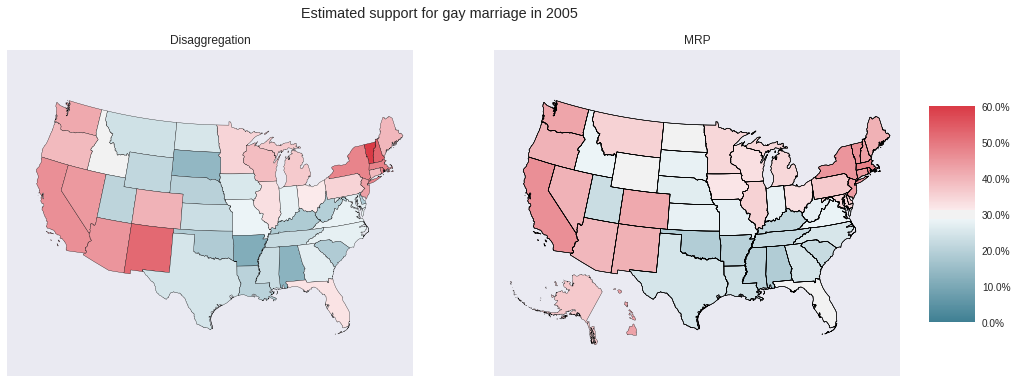

In [48]:
fig, (disagg_ax, mrp_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

fig, disagg_ax, _ = state_plot(disagg_p, p_cmap, p_norm, cbar=False, ax=disagg_ax)
disagg_ax.set_title("Disaggregation");

fig, mrp_ax, cbar_ax = state_plot(ps_mean, p_cmap, p_norm, ax=mrp_ax)
cbar_ax.yaxis.set_major_formatter(p_formatter);
mrp_ax.set_title("MRP");

fig.suptitle("Estimated support for gay marriage in 2005");

Notably, MRP produces opinion estimates for Alaska and Hawaii, which disaggregation does not.  The following scatter plot makes it easier to see how the estimate for each state differs between disaggregation and MRP.

In [49]:
disagg_p_aligned, ps_mean_aligned = disagg_p.align(ps_mean)

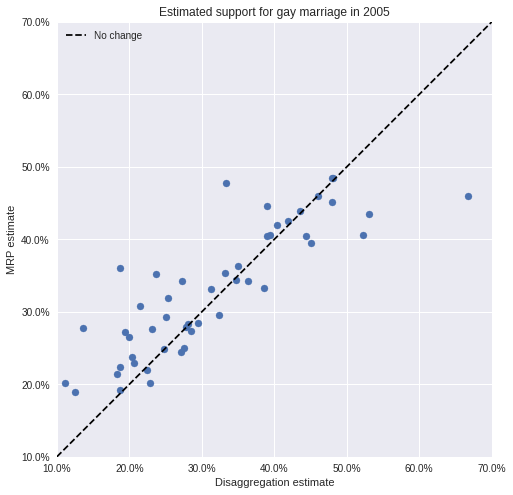

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');

pct_formatter = FuncFormatter(lambda prop, _: '{:.1%}'.format(prop))

ax.plot([0.1, 0.7], [0.1, 0.7], '--', c='k', label="No change");
ax.scatter(disagg_p_aligned, ps_mean_aligned);

ax.set_xlim(0.1, 0.7);
ax.xaxis.set_major_formatter(pct_formatter);
ax.set_xlabel("Disaggregation estimate");

ax.set_ylim(0.1, 0.7);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("MRP estimate");

ax.legend(loc=2);
ax.set_title("Estimated support for gay marriage in 2005");

We see that the MRP estimates tend to be higher than the disaggregation estimates, possibly due to under-sampling of supportive demographic cells in many states.

An additional advantage of MRP is that we can produce better opinion estimates for demographic subsets than disaggregation.  For example, we plot below the disaggregation and MRP estimates of support for gay marriage among black men.  From above, we know disaggregation will not be able to produce an estimate for many states.

In [51]:
black_men_disagg_p = (survey_df[(survey_df.race_wbh == 1) & (survey_df.female == 0)]
                               .groupby('state')
                               .yes_of_all
                               .mean())

black_men_ps_mean = (pp_df[(pp_df.race_wbh == 1) & (pp_df.female == 0)]
                         .groupby('state')
                         .apply(lambda df: (df[PP_COLS].sum(axis=0) / df.freq.sum()))
                         .mean(axis=1))

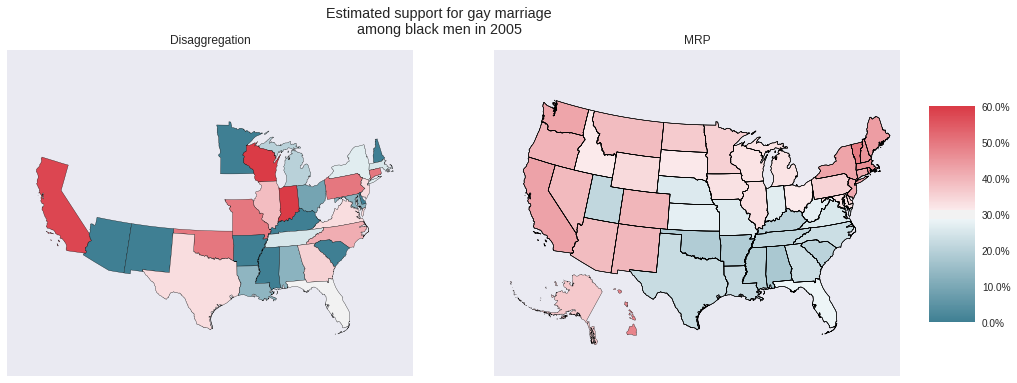

In [52]:
fig, (disagg_ax, mrp_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

fig, disagg_ax, _ = state_plot(black_men_disagg_p, p_cmap, p_norm, cbar=False, ax=disagg_ax)
disagg_ax.set_title("Disaggregation");

fig, mrp_ax, cbar_ax = state_plot(black_men_ps_mean, p_cmap, p_norm, ax=mrp_ax)
cbar_ax.yaxis.set_major_formatter(p_formatter);
mrp_ax.set_title("MRP");

fig.suptitle("Estimated support for gay marriage\namong black men in 2005");

In addition to the gaps in the disaggregation map above, it seems highly unlikely that not a single black man in Minnesota, Arizona, New Mexico, etc. supported gay marriage in 2005.  These disaggregation estimates are due to polling few black men in these states, which MRP attempts to counteract.  For further discussion of estimating the opinions of demographic subgroups using MRP, consult Ghitza and Gelman's [_Deep Interactions with MRP: Election Turnout and Voting Patterns Among Small Electoral Subgroups_](http://www.stat.columbia.edu/~gelman/research/published/misterp.pdf).

One advantage of using the fully Bayesian approach we have taken to MRP via PyMC3 is that we have access to the full posterior distribution of each state's opinion, in addition to the posterior expected values shown in the above choropleth maps.

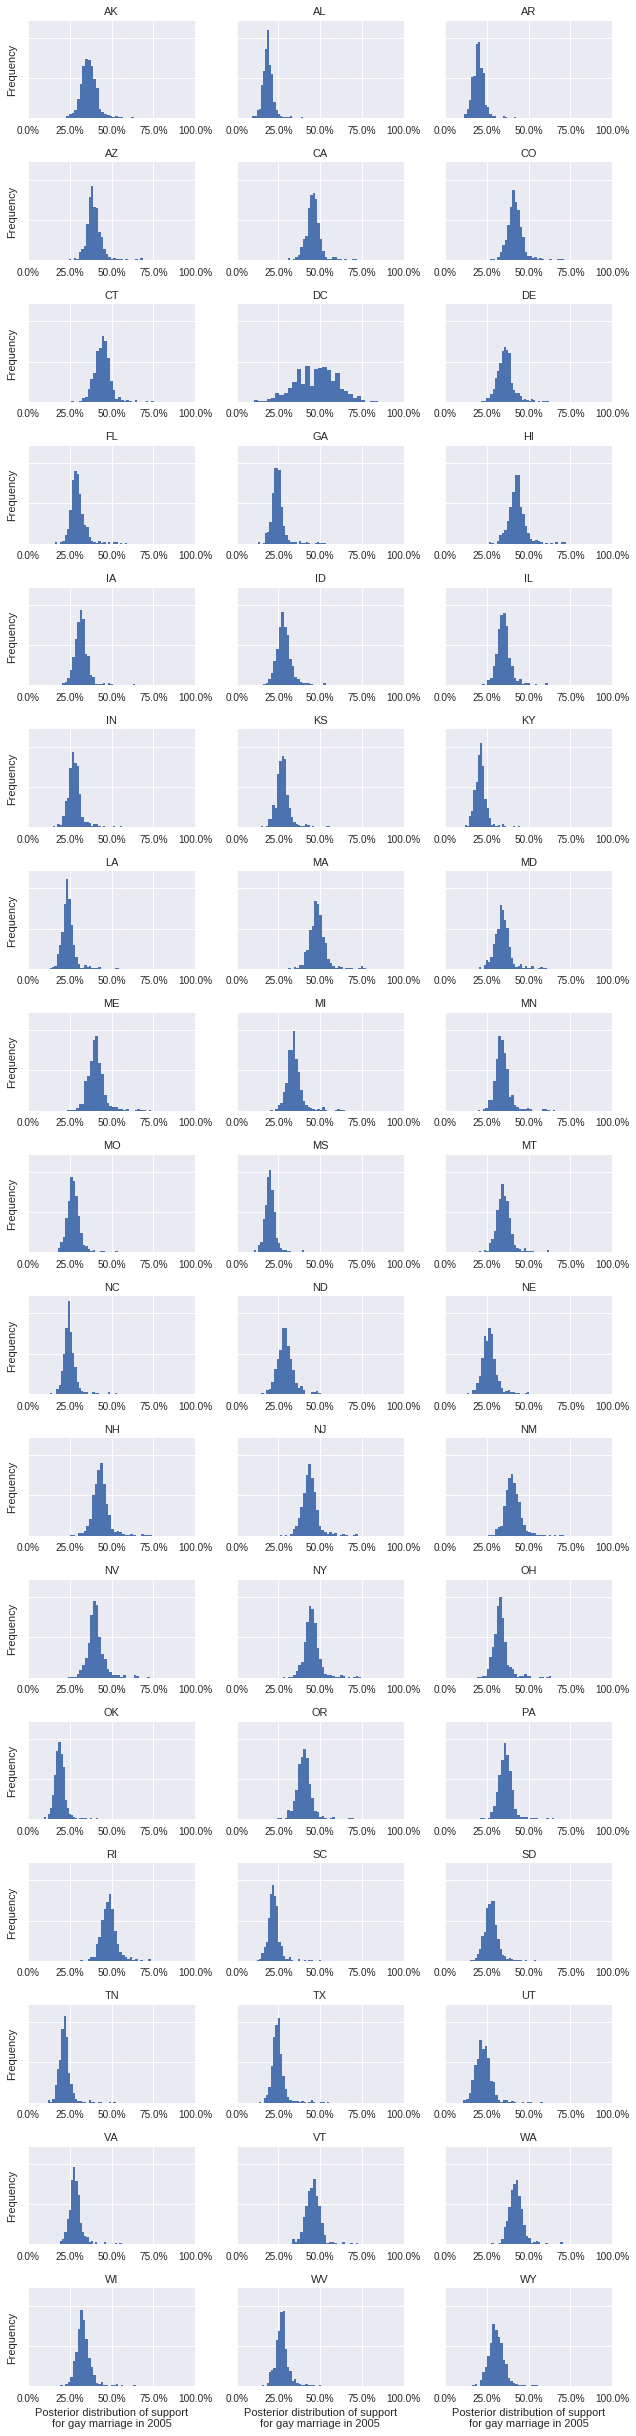

In [53]:
grid = sns.FacetGrid(pd.melt(ps_prob.reset_index(),
                             id_vars='state', value_vars=PP_COLS,
                             var_name='pp_sample', value_name='p'),
                     col='state', col_wrap=3, size=2, aspect=1.5)
grid.map(plt.hist, 'p', bins=30);

grid.set_xlabels("Posterior distribution of support\nfor gay marriage in 2005");

for ax in grid.axes.flat:
    ax.set_xticks(np.linspace(0, 1, 5));
    ax.xaxis.set_major_formatter(pct_formatter);
    plt.setp(ax.get_xticklabels(), visible=True);

grid.set_yticklabels([]);
grid.set_ylabels("Frequency");

grid.fig.tight_layout();
grid.set_titles('{col_name}');

Specifying this model in PyMC3 would certainly have been simpler using [Bambi](https://github.com/bambinos/bambi), which I intend to learn soon for exactly that reason.

I am particularly eager to see what applications MRP will find outside of political science in the coming years.

This post is available as a Jupyter notebook [here](https://gist.github.com/AustinRochford/bfc20cb3262169b41b730bd9faf74477).